In [1]:
import sys
sys.path.insert(0, 'strv-ml-mask2face-master')
sys.path.insert(1, 'FSRCNN-pytorch-master')
sys.path.insert(1, 'Real-ESRGAN-master')

In [2]:
# Necessary imports
import os
import tarfile
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import download_data
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.architectures import UNet
from utils.model import Mask2FaceModel

In [3]:
# setup HW

# is GPU available
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


In [4]:
#Declaring Constants
DATA_PATH = "D:\\fyp\\fyp_final\\data"

# Dataset Preparation

Generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

In [5]:
%cd "D:\\fyp\\fyp_final\\strv-ml-mask2face-master"

D:\fyp\fyp_final\strv-ml-mask2face-master


In [6]:
import shutil

configuration = Configuration()

# setup the pipeline and generate data

dg = DataGenerator(configuration)



In [7]:
train_folder = configuration.get('train_data_path')
test_folder = configuration.get('test_data_path')

if os.path.exists(train_folder) and os.path.exists(test_folder):
    print('Testing and training data already generated')
else:
    dg.generate_images()

Testing and training data already generated


Here are few examples of generated data.
data/train\outputs\051266.png
data/train\outputs\069973.png
data/train\outputs\142244.png


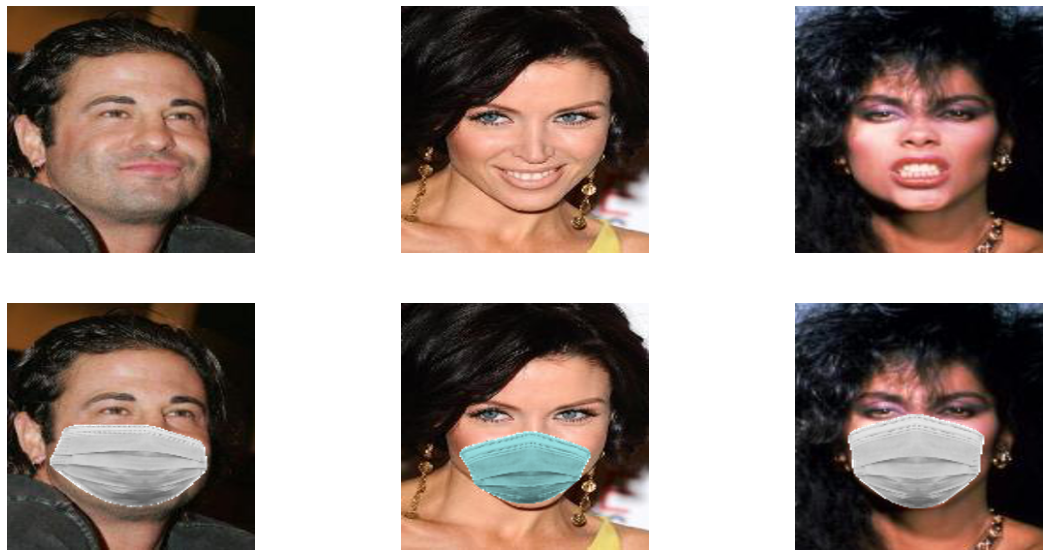

In [54]:
print('Here are few examples of generated data.')

n_examples = 3
inputs, outputs = dg.get_dataset_examples(n_examples)
f, axarr = plt.subplots(2, n_examples, figsize=(20, 10))
for i in range(len(inputs)):
    axarr[1, i].imshow(mpimg.imread(inputs[i]))
    axarr[1, i].axis('off')
    axarr[0, i].imshow(mpimg.imread(outputs[i]))
    axarr[0, i].axis('off')
    print(outputs[i])
    shutil.copy(inputs[i],DATA_PATH)
    shutil.copy(outputs[i],os.path.join(DATA_PATH, 'nomask'))

# Defining helper functions

In [8]:
# utils for visualization
import cv2
import matplotlib.pyplot as plt
def display(img1, img2, img3):
  fig = plt.figure(figsize=(10, 10))

  img1 = np.asarray(img1)
  img1 = tf.clip_by_value(img1, 0, 255)
  img1 = Image.fromarray(tf.cast(img1, tf.uint8).numpy())
  ax1 = fig.add_subplot(1, 3, 1) 
  plt.title('Input image', fontsize=16)
  ax1.axis('off')


  img2 = np.asarray(img2)
  img2 = tf.clip_by_value(img2, 0, 255)
  img2 = Image.fromarray(tf.cast(img2, tf.uint8).numpy())
  ax2 = fig.add_subplot(1, 3, 2)
  plt.title('Output', fontsize=16)
  ax2.axis('off')


  img3 = np.asarray(img3)
  img3 = tf.clip_by_value(img3, 0, 255)
  img3 = Image.fromarray(tf.cast(img3, tf.uint8).numpy())
  ax3 = fig.add_subplot(1, 3, 3)
  plt.title('Original image', fontsize=16)
  ax3.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
  ax3.imshow(img3)


def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

# display each image in the upload folder
import os
import glob



In [9]:
import cv2
import numpy as np

def selectROI(img_path):
    #image_path
    img_path=img_path
    #read image
    img_raw = cv2.imread(img_path)
    #select ROIs function
    ROIs = cv2.selectROIs("Select Rois",img_raw)
    #print rectangle points of selected roi
    print(ROIs)

    #Crop selected roi ffrom raw image

    #counter to save image with different name
    crop_number=0 

    #loop over every bounding box save in array "ROIs"
    for rect in ROIs:
        x1=rect[0]
        y1=rect[1]
        x2=rect[2]
        y2=rect[3]

        #crop roi from original image
        img_crop=img_raw[y1:y1+y2,x1:x1+x2]
        #show cropped image
        cv2.imshow("crop"+str(crop_number),img_crop)
        #save cropped image
        cv2.imwrite("crop"+str(crop_number)+".jpeg",img_crop)
        crop_number+=1

    #hold window
    cv2.waitKey(0)
    
def boundingRect(img_path):
    image = cv2.imread(img_path)
    cv2.imshow("image",image)
    gray =cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imshow("Changed",gray)
    ret,binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(binary,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    print("Number of contours:" + str(len(contours)))
    x,y,w,h = cv2.boundingRect(contours[0])
    cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),3)
    cv2.imshow("result",image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [10]:
from PIL import Image
import os
def downscale_image(image):
    image_size=[]
    if len(image.shape) ==3:
        image_size= [image.shape[1], image.shape[0]]
    else:
        raise ValueError("Dimension mismatch. Can only work on single image")
    
    image = tf.squeeze(
        tf.cast(
            tf.clip_by_value(image,0,255), tf.uint8))
    
    lr_image=np.asarray(
        Image.fromarray(image.numpy())
        .resize([image_size[0] // 2, image_size[1] // 2],
               Image.BICUBIC))
    
    #lr_image=tf.expand_dims(lr_image, 0)
    lr_image=tf.cast(lr_image,tf.float32)
    return lr_image

def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]

    
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])

  hr_image = tf.cast(hr_image, tf.float32)

  #return tf.expand_dims(hr_image, 0)
  return hr_image

def save_image(image, image_path, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save(f"{image_path}%s" % filename)
  print("Saved as %s" % filename)

In [11]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  fig = plt.figure(figsize=(5,5))
  ax1 = fig.add_subplot(1,1,1)
  ax1.axis("off")
  plt.title(title)
  ax1.imshow(image)


In [56]:
##RESIZE INPUT IMAGE
input_folder = os.path.join(DATA_PATH, 'normal')
#result_folder = os.path.join(DATA_PATH, 'LR')
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
#output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
#ori_list = sorted(glob.glob(os.path.join(DATA_PATH, '*')))

for input_path in input_list:
  img_input = imread(input_path)
  #selectROI(input_path)
  #boundingRect(input_path)
  hr_image = preprocess_image(input_path)

  #resizing
  dimensions=(512,512)
  hr_image = cv2.resize(np.float32(hr_image), dimensions, interpolation=cv2.INTER_LINEAR)


  # Saving Low Resolution Image
  hr_path ="D:\\fyp\\fyp_final\\data\\normal\\resized\\"
  head,tail = os.path.split(input_path)
  save_image(hr_image, hr_path, tail)


Saved as 006046.png
Saved as 010842.png
Saved as 013897.png
Saved as 014548.png
Saved as 015960.png
Saved as 051266.png
Saved as 069973.png
Saved as 142244.png


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-9d_dfo3_\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Saved as 006046.png
PSNR Achieved: 33.111351 
SSIM Achieved: 0.934478 
Saved as 010842.png
PSNR Achieved: 33.129089 
SSIM Achieved: 0.938793 
Saved as 013897.png
PSNR Achieved: 34.605068 
SSIM Achieved: 0.942030 
Saved as 014548.png
PSNR Achieved: 30.754097 
SSIM Achieved: 0.867198 
Saved as 015960.png
PSNR Achieved: 32.103619 
SSIM Achieved: 0.939354 


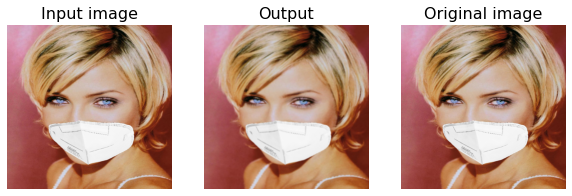

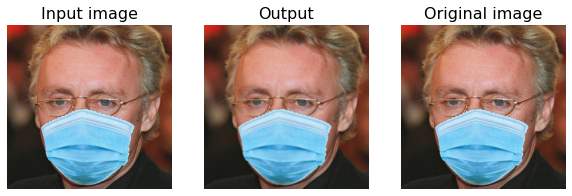

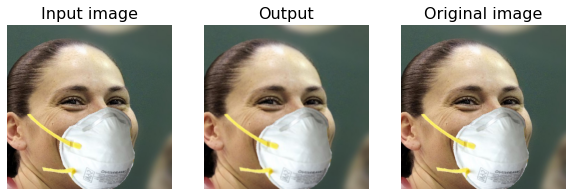

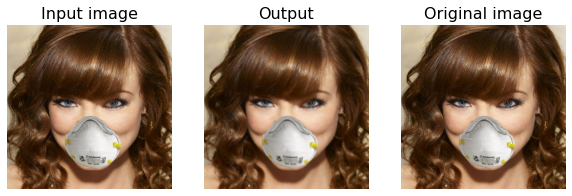

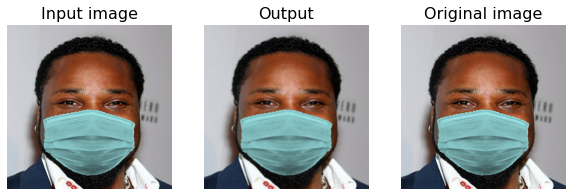

In [23]:
input_folder = os.path.join(DATA_PATH, 'normal\\resized')
#result_folder = os.path.join(DATA_PATH, 'LR')
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
#output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
#ori_list = sorted(glob.glob(os.path.join(DATA_PATH, '*')))

for input_path in input_list:
  img_input = imread(input_path)
  #selectROI(input_path)
  #boundingRect(input_path)
  hr_image = preprocess_image(input_path)

  lr_image = downscale_image(tf.squeeze(hr_image))


  # Saving Low Resolution Image
  lr_path ="D:\\fyp\\fyp_final\\data\\LR\\"
  head,tail = os.path.split(input_path)
  save_image(lr_image, lr_path, tail)

  #resizing for evaluation purposes
  dimensions=(512,512)
  hr_image = cv2.resize(np.float32(hr_image), dimensions, interpolation=cv2.INTER_LINEAR)
  lr_image = cv2.resize(np.float32(lr_image), dimensions, interpolation=cv2.INTER_LINEAR)

  psnr = tf.image.psnr(
      tf.clip_by_value(lr_image,0,255),
      tf.clip_by_value(hr_image,0,255), max_val=255)
  print("PSNR Achieved: %f " %psnr)

  
  ssim = tf.image.ssim(
      tf.clip_by_value(lr_image,0,255),
      tf.clip_by_value(hr_image,0,255), max_val=255)
  print("SSIM Achieved: %f " %ssim)
  
  display(img_input, lr_image, img_input)


In [57]:
%cd "D:\\fyp\\fyp_final\\matlab_imresize-master"

D:\fyp\fyp_final\matlab_imresize-master


In [66]:
import numpy as np
from skimage.io import imsave, imread
from skimage import img_as_float
import sys
sys.path.append('..')
from imresize import *

input_img = os.path.join(DATA_PATH, 'normal\\resized\\142244.png')
result_img = os.path.join(DATA_PATH, 'LR\\142244.png')


# 1. Load original image and do imresize+save both im UINT8 and FLOAT64 types
img_uint8 = imread(input_img)

img_double = img_as_float(img_uint8)
new_img_double = imresize(img_double, scalar_scale=0.25)
imsave(result_img, convertDouble2Byte(new_img_double))



(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
PSNR Achieved: 28.776054 
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
PSNR Achieved: 29.048048 
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
PSNR Achieved: 30.631094 
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
PSNR Achieved: 27.828545 
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
PSNR Achieved: 27.650381 
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
PSNR Achieved: 35.735233 
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
PSNR Achieved: 34.142307 
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
PSNR Achieved: 36.083015 


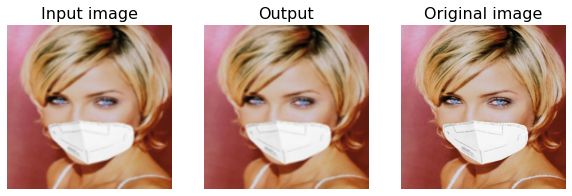

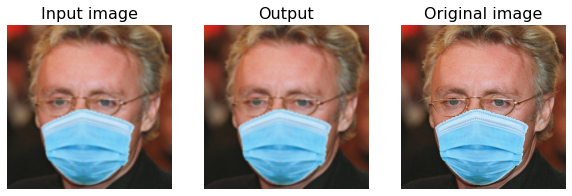

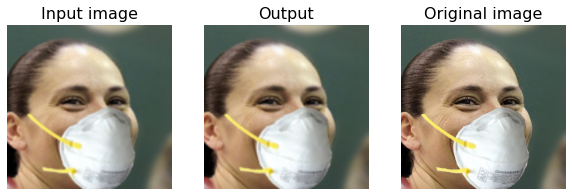

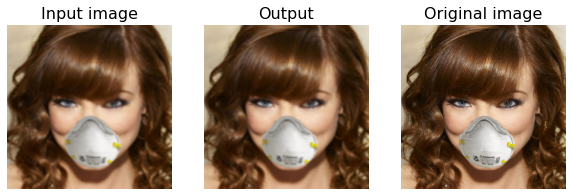

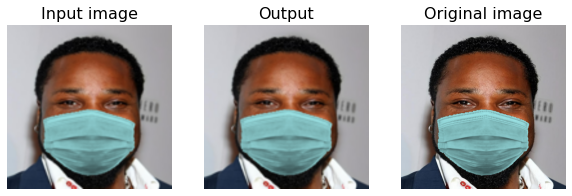

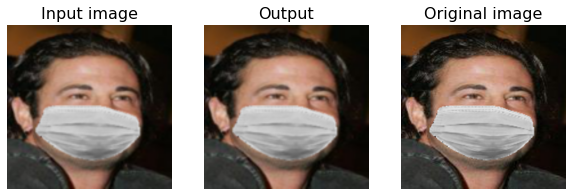

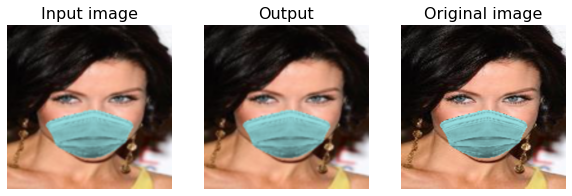

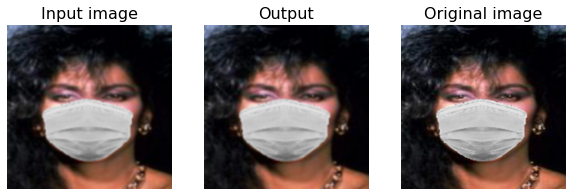

In [67]:
input_folder = os.path.join(DATA_PATH, 'LR')
result_folder = os.path.join(DATA_PATH, 'LR')
ori_folder = os.path.join(DATA_PATH, 'normal\\resized')

input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
ori_list = sorted(glob.glob(os.path.join(ori_folder, '*')))

for input_path, output_path, ori_path in zip(input_list, output_list, ori_list):
  img_input = imread(input_path)

  #selectROI(input_path)
  #boundingRect(input_path)
  #hr_image = preprocess_image(input_path)
    

  dimensions=(512,512)
  


  img_input = cv2.resize(np.float32(img_input), dimensions, interpolation=cv2.INTER_LINEAR)
  print(img_input.shape)
    
  img_output = imread(output_path)
  img_output = cv2.resize(np.float32(img_output), dimensions, interpolation=cv2.INTER_LINEAR)
  print(img_output.shape)


  img_ori = imread(ori_path)
  img_ori = cv2.resize(np.float32(img_ori), dimensions, interpolation=cv2.INTER_LINEAR)
  print(img_ori.shape)



  psnr = tf.image.psnr(
      tf.clip_by_value(img_input,0,255),
      tf.clip_by_value(img_ori,0,255), max_val=255)
  print("PSNR Achieved: %f " %psnr)
  

  display(img_input, img_output, img_ori)


# FSRCNN

In [68]:
%cd "D:\fyp\fyp_final\FSRCNN-pytorch-master"

D:\fyp\fyp_final\FSRCNN-pytorch-master


In [25]:
!python test.py --weights-file "weights/fsrcnn_x4.pth" \
               --image-file "D:\\fyp\\fyp_final\\data\\LR\\015960_double.png" \
               --scale 4

006046_double.png 
PSNR Achieved: 29.786659 
SSIM Achieved: 0.843621 

010842_double.png 
PSNR Achieved: 29.884037 
SSIM Achieved: 0.837468 

013897_double.png 
PSNR Achieved: 31.538872 
SSIM Achieved: 0.864331 

014548_double.png 
PSNR Achieved: 28.355619 
SSIM Achieved: 0.748408 

015960_double.png 
PSNR Achieved: 29.084614 
SSIM Achieved: 0.857454 



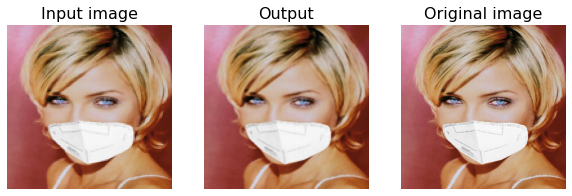

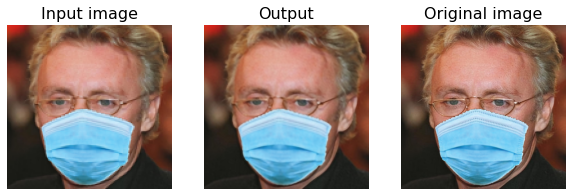

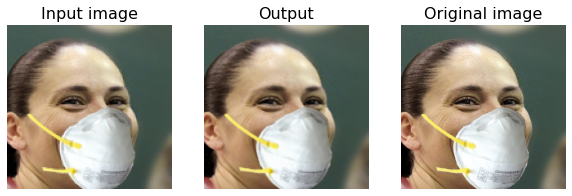

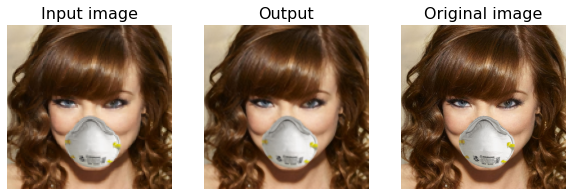

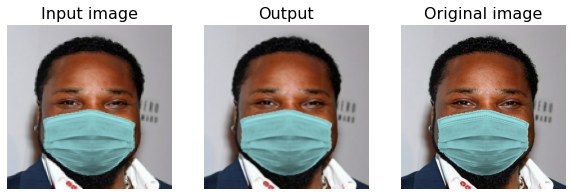

In [35]:
input_folder = os.path.join(DATA_PATH, 'LR')
result_folder = os.path.join(DATA_PATH, 'fsrcnn')
ori_folder = os.path.join(DATA_PATH, 'normal\\resized')

input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
ori_list = sorted(glob.glob(os.path.join(ori_folder, '*')))

for input_path, output_path, ori_path in zip(input_list, output_list, ori_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  img_ori = imread(ori_path)


  dimensions=(512,512)
  img_ori = cv2.resize(np.float32(img_ori), dimensions, interpolation=cv2.INTER_LINEAR)
  #img_input = cv2.resize(np.float32(img_input), dimensions, interpolation=cv2.INTER_LINEAR)
  img_output = cv2.resize(np.float32(img_output), dimensions, interpolation=cv2.INTER_LINEAR)

  head,tail = os.path.split(input_path)


  psnr = tf.image.psnr(
      tf.clip_by_value(img_ori,0,255),
      tf.clip_by_value(img_output,0,255), max_val=255)
  print(f"{tail} \nPSNR Achieved: %f " %psnr)

  ssim = tf.image.ssim(
      tf.clip_by_value(img_output,0,255),
      tf.clip_by_value(img_ori,0,255), max_val=255)
  print("SSIM Achieved: %f \n" %ssim)
  

  display(img_input, img_output, img_ori)


# ESRGAN

In [36]:
%cd "D:\fyp\fyp_final\Real-ESRGAN-master"

D:\fyp\fyp_final\Real-ESRGAN-master


In [21]:
!python setup.py develop

running develop
running egg_info
writing manifest file 'realesrgan.egg-info\SOURCES.txt'
running build_ext
Installing gfpgan-0.2.4-py3-none-any.whl to c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages
Installing facexlib-0.2.1.1-py3-none-any.whl to c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages
No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.5'

C:\Users\KHAL0009\Anaconda3\envs\mask2face\lib\site-packages\setuptools\installer.py:27: SetuptoolsDeprecationWarning: setuptools.installer is deprecated. Requirements should be satisfied by a PEP 517 installer.
  warnings.warn(
C:\Users\KHAL0009\Anaconda3\envs\mask2face\lib\site-packages\setuptools\command\easy_install.py:156: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(



creating c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg
Extracting basicsr-1.3.4.9-py3.8.egg to c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\__init__.py to __init__.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\test.py to test.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\train.py to train.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\version.py to version.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\archs\__init__.py to __init__.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-

C:\Users\KHAL0009\Anaconda3\envs\mask2face\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
C:\Users\KHAL0009\Anaconda3\envs\mask2face\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning:  is an invalid version and will not be supported in a future release
  warnings.warn(
C:\Users\KHAL0009\Anaconda3\envs\mask2face\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
C:\Users\KHAL0009\Anaconda3\envs\mask2face\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning:  is an invalid version and will not be supported in a future release
  warnings.warn(
C:\Users\KHAL0009\Anaconda3\envs\mask2face\lib\site-packages\setuptools\dist.py:723: UserWarning: Usage of dash-separated 'descrip


byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\archs\swinir_arch.py to swinir_arch.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\archs\tof_arch.py to tof_arch.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\archs\vgg_arch.py to vgg_arch.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\data\__init__.py to __init__.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\data\data_sampler.py to data_sampler.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\basicsr-1.3.4.9-py3.8.egg\basicsr\data\data_util.py to data_util.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2fac

byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\future-0.18.2-py3.8.egg\future\types\__init__.py to __init__.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\future-0.18.2-py3.8.egg\future\types\newbytes.py to newbytes.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\future-0.18.2-py3.8.egg\future\types\newdict.py to newdict.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\future-0.18.2-py3.8.egg\future\types\newint.py to newint.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\future-0.18.2-py3.8.egg\future\types\newlist.py to newlist.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\future-0.18.2-py3.8.egg\future\types\newmemoryview.py to newmemoryview.cpython-38.pyc
byte-compiling c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\future-0.1

Installing lsm2bin-script.py script to C:\Users\KHAL0009\Anaconda3\envs\mask2face\Scripts
Installing lsm2bin.exe script to C:\Users\KHAL0009\Anaconda3\envs\mask2face\Scripts
Installing tiff2fsspec-script.py script to C:\Users\KHAL0009\Anaconda3\envs\mask2face\Scripts
Installing tiff2fsspec.exe script to C:\Users\KHAL0009\Anaconda3\envs\mask2face\Scripts
Installing tiffcomment-script.py script to C:\Users\KHAL0009\Anaconda3\envs\mask2face\Scripts
Installing tiffcomment.exe script to C:\Users\KHAL0009\Anaconda3\envs\mask2face\Scripts
Installing tifffile-script.py script to C:\Users\KHAL0009\Anaconda3\envs\mask2face\Scripts
Installing tifffile.exe script to C:\Users\KHAL0009\Anaconda3\envs\mask2face\Scripts

Installed c:\users\khal0009\anaconda3\envs\mask2face\lib\site-packages\tifffile-2021.11.2-py3.8.egg
Searching for networkx>=2.2
Reading https://pypi.org/simple/networkx/
Best match: networkx 2.6.3
Processing networkx-2.6.3-py3-none-any.whl
Installing networkx-2.6.3-py3-none-any.whl to

In [42]:
!python inference_realesrgan.py --input "D:\\fyp\\fyp_final\\data\\LR" --model_path "experiments\\pretrained_models\\ESRGAN_PSNR_SRx4_DF2K_official-150ff491.pth" --outscale 4 --tile 64
# Arguments
# -n, --model_name: Model names
# -i, --input: input folder or image
# --outscale: Output scale, can be arbitrary scale factore. 

Testing 0 006046_double
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Testing 1 010842_double
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Testing 2 013897_double
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Testing 3 014548_double
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Testing 4 015960_double
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4


## Visualisation

006046_double.png
PSNR Achieved: 33.065956 
 New PSNR Achieved: 33.065958 
SSIM Achieved: 0.911977

010842_double.png
PSNR Achieved: 32.275101 
 New PSNR Achieved: 32.275102 
SSIM Achieved: 0.890375

013897_double.png
PSNR Achieved: 33.530575 
 New PSNR Achieved: 33.530575 
SSIM Achieved: 0.905467

014548_double.png
PSNR Achieved: 29.501560 
 New PSNR Achieved: 29.501561 
SSIM Achieved: 0.803858

015960_double.png
PSNR Achieved: 32.261185 
 New PSNR Achieved: 32.261188 
SSIM Achieved: 0.911395



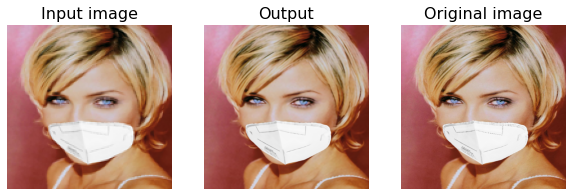

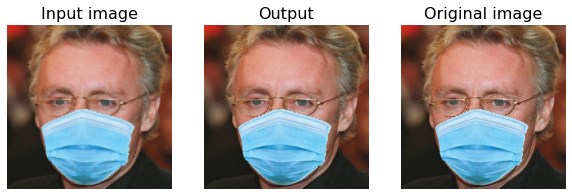

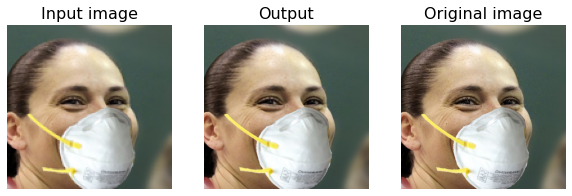

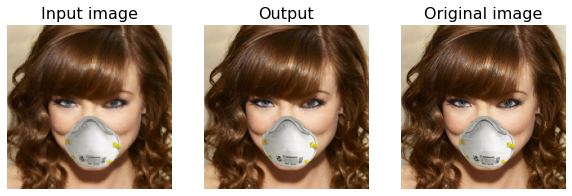

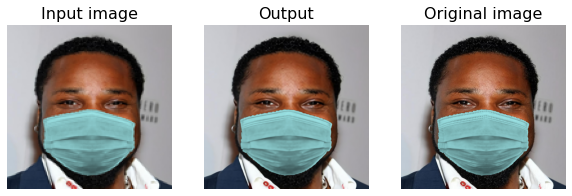

In [43]:
import numpy as np
def calc_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

input_folder = os.path.join(DATA_PATH, 'LR')
#result_folder = os.path.join(DATA_PATH, 'ESRGAN')
result_folder = 'results'

ori_folder = os.path.join(DATA_PATH, 'normal\\resized')

input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
ori_list = sorted(glob.glob(os.path.join(ori_folder, '*')))

for input_path, output_path, ori_path in zip(input_list, output_list, ori_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  img_ori = imread(ori_path)


  dimensions=(512,512)
  img_ori = cv2.resize(np.float32(img_ori), dimensions, interpolation=cv2.INTER_LINEAR)
  #img_input = cv2.resize(np.float32(img_input), dimensions, interpolation=cv2.INTER_LINEAR)
  img_output = cv2.resize(np.float32(img_output), dimensions, interpolation=cv2.INTER_LINEAR)

  head,tail = os.path.split(input_path)


  psnr = tf.image.psnr(
      tf.clip_by_value(img_output,0,255),
      tf.clip_by_value(img_ori,0,255), max_val=255)
  print(f"{tail}\nPSNR Achieved: %f " %psnr)
  newpsnr=calc_psnr(img_output, img_ori)
  print(" New PSNR Achieved: %f " %newpsnr)

  ssim = tf.image.ssim(
      tf.clip_by_value(img_output,0,255),
      tf.clip_by_value(img_ori,0,255), max_val=255)
  print("SSIM Achieved: %f\n" %ssim)

  display(img_input, img_output, img_ori)
  

In [165]:
####ESRGAN
%cd "C:\Users\KHAL0009\Desktop\fyp\mask2face\ESRGAN-master"

C:\Users\KHAL0009\Desktop\fyp\mask2face\ESRGAN-master


PSNR Achieved: 27.911163 
PSNR Achieved: 28.884285 
PSNR Achieved: 29.988972 
PSNR Achieved: 28.548685 
PSNR Achieved: 26.726070 


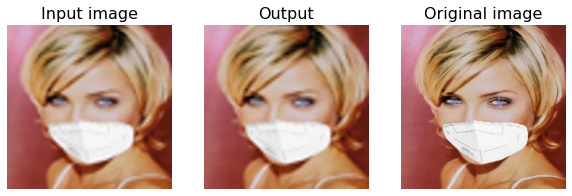

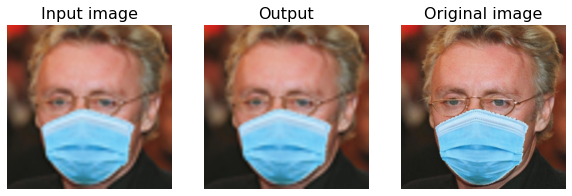

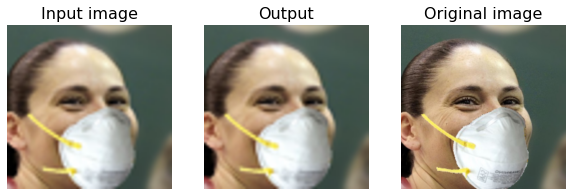

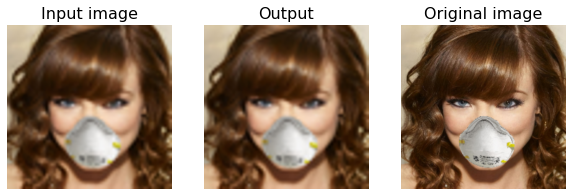

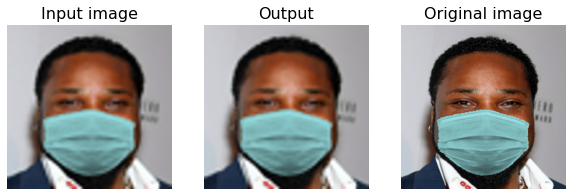

In [196]:
import matplotlib.pyplot as plt
import numpy as np


input_folder = os.path.join(DATA_PATH, 'LR')
result_folder = os.path.join(DATA_PATH, 'esrgan')
ori_folder = os.path.join(DATA_PATH, 'normal\\resized')

input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
ori_list = sorted(glob.glob(os.path.join(ori_folder, '*')))

for input_path, output_path, ori_path in zip(input_list, output_list, ori_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  img_ori = imread(ori_path)
  dimensions =(1024, 1024)
  img_ori = cv2.resize(img_ori, dimensions, interpolation=cv2.INTER_LINEAR)

  img_output = cv2.resize(img_output, dimensions, interpolation=cv2.INTER_LINEAR)
  psnr = tf.image.psnr(
      tf.clip_by_value(img_output,0,255),
      tf.clip_by_value(img_ori,0,255), max_val=255)
  print("PSNR Achieved: %f " %psnr)

  display(img_input, img_output, img_ori)
  

# Mask2Face

In [44]:
%cd "C:\Users\KHAL0009\Desktop\fyp\mask2face\strv-ml-mask2face-master"

C:\Users\KHAL0009\Desktop\fyp\mask2face\strv-ml-mask2face-master


In [45]:
#Model Training
filters = (64, 128, 128, 256, 256, 512)
kernels = (7, 7, 7, 3, 3, 3)
input_image_size = (256, 256, 3)
architecture = UNet.RESNET
training_epochs = 20
batch_size = 12

In [46]:
# Create instance of model and start training
#model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
#                                   kernels=kernels, configuration=configuration)
#model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

# Load existing pretrained model
model = Mask2FaceModel.load_model('models/model_epochs-20_batch-12_loss-ssim_l1_loss_20220121_08_41_34.h5')

## Visualisation

['data/test\\inputs\\015933.png', 'data/test\\inputs\\010356.png', 'data/test\\inputs\\017240.png', 'data/test\\inputs\\014179.png', 'data/test\\inputs\\008411.png']
No keypoints detected on image
(512, 512)
(512, 512)
(506, 512)
(512, 512)
(495, 512)
Outputs generated on previously unseen data.


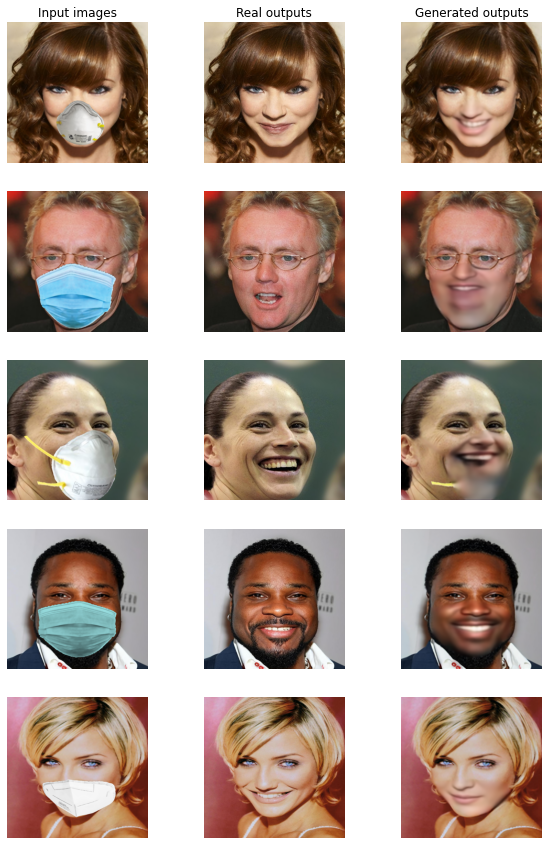

In [53]:
import random

# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 5
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=True)
print(input_imgs)
images = os.listdir(os.path.join(DATA_PATH, 'esrgan'))
images = random.sample(images, n_examples)
inputs = [os.path.join(DATA_PATH, 'esrgan', img) for img in images]
outputs = [os.path.join(DATA_PATH,'nomask', img) for img in images]
f, axarr = plt.subplots(n_examples,3, figsize=(10, n_examples * 3))
for i, img in enumerate(inputs):
    
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(inputs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(outputs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')
    

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')

print('Outputs generated on previously unseen data.')

['data/test\\inputs\\002611.png', 'data/test\\inputs\\010233.png', 'data/test\\inputs\\003124.png', 'data/test\\inputs\\010918.png', 'data/test\\inputs\\012864.png']
(504, 512)
(512, 512)
(489, 512)
No keypoints detected on image
(512, 512)
(512, 512)
Outputs generated on previously unseen data.


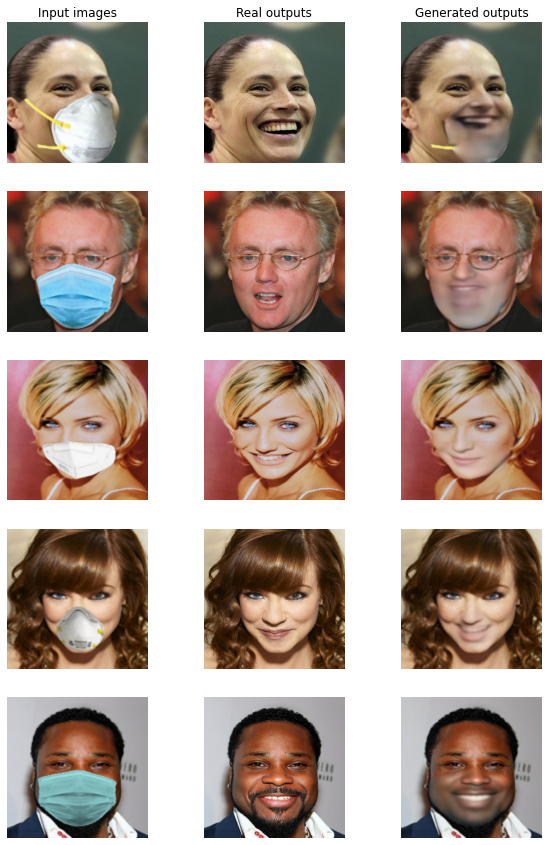

In [49]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 5
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=True)
print(input_imgs)
images = os.listdir(os.path.join(DATA_PATH, 'fsrcnn'))
images = random.sample(images, n_examples)
inputs = [os.path.join(DATA_PATH, 'fsrcnn', img) for img in images]
outputs = [os.path.join(DATA_PATH,'nomask', img) for img in images]
f, axarr = plt.subplots(n_examples,3, figsize=(10, n_examples * 3))
for i, img in enumerate(inputs):
    
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(inputs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(outputs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    generated_output.save('test.png')
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')

print('Outputs generated on previously unseen data.')

['data/test\\inputs\\006501.png', 'data/test\\inputs\\004952.png', 'data/test\\inputs\\006869.png', 'data/test\\inputs\\008969.png', 'data/test\\inputs\\009576.png']
(124, 128)
(128, 128)
(128, 128)
No keypoints detected on image
(128, 128)
(121, 128)
Outputs generated on previously unseen data.


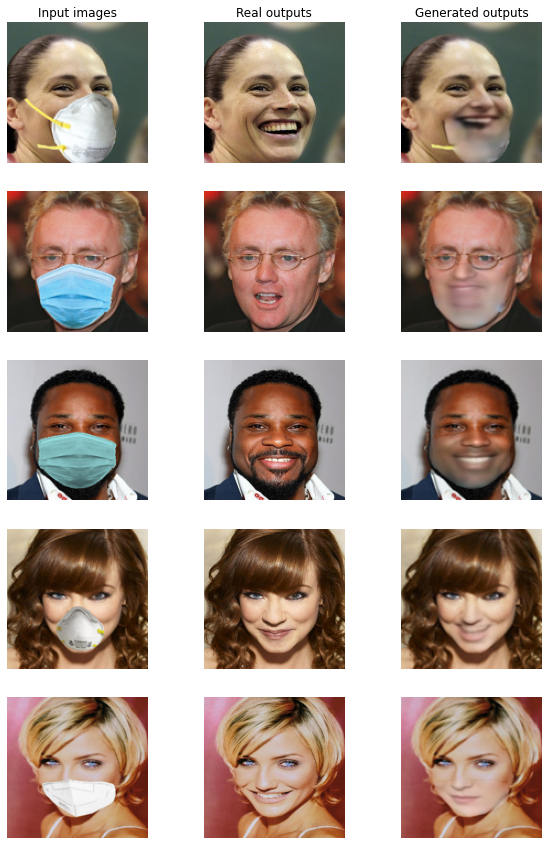

In [51]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 5
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=True)
print(input_imgs)
images = os.listdir(os.path.join(DATA_PATH, 'LR'))
images = random.sample(images, n_examples)
inputs = [os.path.join(DATA_PATH, 'LR', img) for img in images]
outputs = [os.path.join(DATA_PATH,'nomask', img) for img in images]
f, axarr = plt.subplots(n_examples,3, figsize=(10, n_examples * 3))
for i, img in enumerate(inputs):
    
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(inputs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(outputs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    generated_output.save('test.png')
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')

print('Outputs generated on previously unseen data.')

In [ ]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 5
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=True)
print(input_imgs)
images = os.listdir(os.path.join(DATA_PATH, 'fsrcnn'))
images = random.sample(images, n_examples)
inputs = [os.path.join(DATA_PATH, 'fsrcnn', img) for img in images]
outputs = [os.path.join(DATA_PATH,'nomask', img) for img in images]
f, axarr = plt.subplots(n_examples,3, figsize=(10, n_examples * 3))
for i, img in enumerate(inputs):
    
    generated_output = model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(inputs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(outputs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    generated_output.save('test.png')
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')

print('Outputs generated on previously unseen data.')